In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import report_ensemble
from diabnet.ensemble import Ensemble
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import bootstrap
import scipy.stats as st
# warnings.simplefilter(action='ignore', category=FutureWarning)
# sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-', 'grid.zorder': 0})
# sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '--'})
COLORS = sns.color_palette("colorblind")



In [2]:
ensemble = Ensemble('../data/models/model-positive-9-adamw-lc1-2021-02-05')

../data/models/model-positive-9-adamw-lc1-2021-02-05


In [3]:
r = report_ensemble.DiabNetReport(ensemble, "positivo_1000_random_0.csv")

NEGATIVE FILE ../data/datasets/visits_sp_unique_test_positivo_1000_random_0_negatives_older60.csv


In [4]:
def ece_mce_t_p(preds, targets, bins=10):
    lower_bound = np.arange(0.0, 1.0, 1.0/bins)
    upper_bound = lower_bound + 1.0/bins
    
    ece = np.zeros(1)
    mce = np.zeros(1)
    t = np.zeros(bins)
    p = np.zeros(bins)
    interval_min = np.zeros(bins)
    interval_max = np.zeros(bins)
    
    
    
    for i in range(bins):
        mask = (preds > lower_bound[i]) * (preds <= upper_bound[i])
        if np.any(mask):
#             print(lower_bound[i], upper_bound[i])
#             print(preds[mask])
#             print(targets[mask])
            t[i] = np.mean(targets[mask])
            p[i] = np.mean(preds[mask])
            # num of bootstraps is equal to  
            data = bootstrap(targets[mask], bootnum=10000, bootfunc=lambda x: np.mean(x) - t[i])
            data = np.sort(data)
#             np.sort(data)
            #print(st.sem(data))
            #interval_min[i], interval_max[i] = st.t.interval(alpha=0.95, df=len(data)-1, loc=t[i], scale=st.sem(data))
#             t[i], _, _, ci = jackknife_stats(targets[mask], np.mean, 0.95)
            interval_min[i], interval_max[i] = data[249], data[9749]
            delta = np.abs(np.mean(preds[mask]) - np.mean(targets[mask]))
            ece += delta * np.mean(mask)
            mce = np.maximum(mce, delta)
#             print(ece, mce)
            
#     print(interval_min)
#     print(interval_max)
    return ece, mce, t, p, np.stack([np.abs(interval_min), interval_max])

In [5]:
df = pd.DataFrame(r.dataset_test_unique.features)
df.columns = r.feat_names
df['T2D'] = r.dataset_test_unique.labels
df['Pred'] = r.dataset_test_unique.predictions
# correction for soft_label_baseline
# baseline = 0.20
# df['Pred'] = (r.dataset_test_unique.predictions - 0.33)/(0.9 - 0.33)

In [6]:
df = pd.DataFrame(r.dataset_test_unique_subset_older50.features)
df.columns = r.feat_names
df['T2D'] = r.dataset_test_unique_subset_older50.labels
df['Pred'] = r.dataset_test_unique_subset_older50.predictions

In [7]:
df

,snp_8_133462953,snp_2_91635413,snp_9_25963828,snp_1_17764169,snp_12_41767967,snp_4_49530811,snp_2_96519717,snp_7_116910447,snp_18_56742728,snp_3_75912490,...,snp_20_50189624,snp_1_143276644,snp_16_9536673,snp_20_25734788,AGE,sex,mo_t2d,fa_t2d,T2D,Pred
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,51,M,2,2,1,0.887822
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,52,F,0,2,1,0.266107
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,53,F,1,1,1,0.993755
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,39,F,2,0,1,0.999747
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,61,F,2,2,0,0.394996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0,1,0,1,0,1,1,0,0,1,...,0,1,0,1,52,M,2,2,1,0.835504
316,0,0,1,0,0,1,0,0,0,0,...,1,1,0,0,38,F,1,1,1,0.752775
317,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,54,F,2,2,1,0.993580
318,0,0,1,0,0,0,0,0,0,0,...,2,0,0,0,67,F,2,2,0,0.002868


In [8]:
ece, mce, t, p, ece_ci = ece_mce_t_p(df['Pred'].values, df['T2D'].values)

In [9]:
print(ece, mce)
ece_ci

[0.07727616] [0.17126203]


array([[0.07142857, 0.13333333, 0.14285714, 0.2       , 0.25      ,
        0.2       , 0.1875    , 0.15      , 0.13636364, 0.        ],
       [0.07142857, 0.13333333, 0.14285714, 0.2       , 0.25      ,
        0.2       , 0.1875    , 0.15      , 0.09090909, 0.        ]])

(-0.0, 1.0)

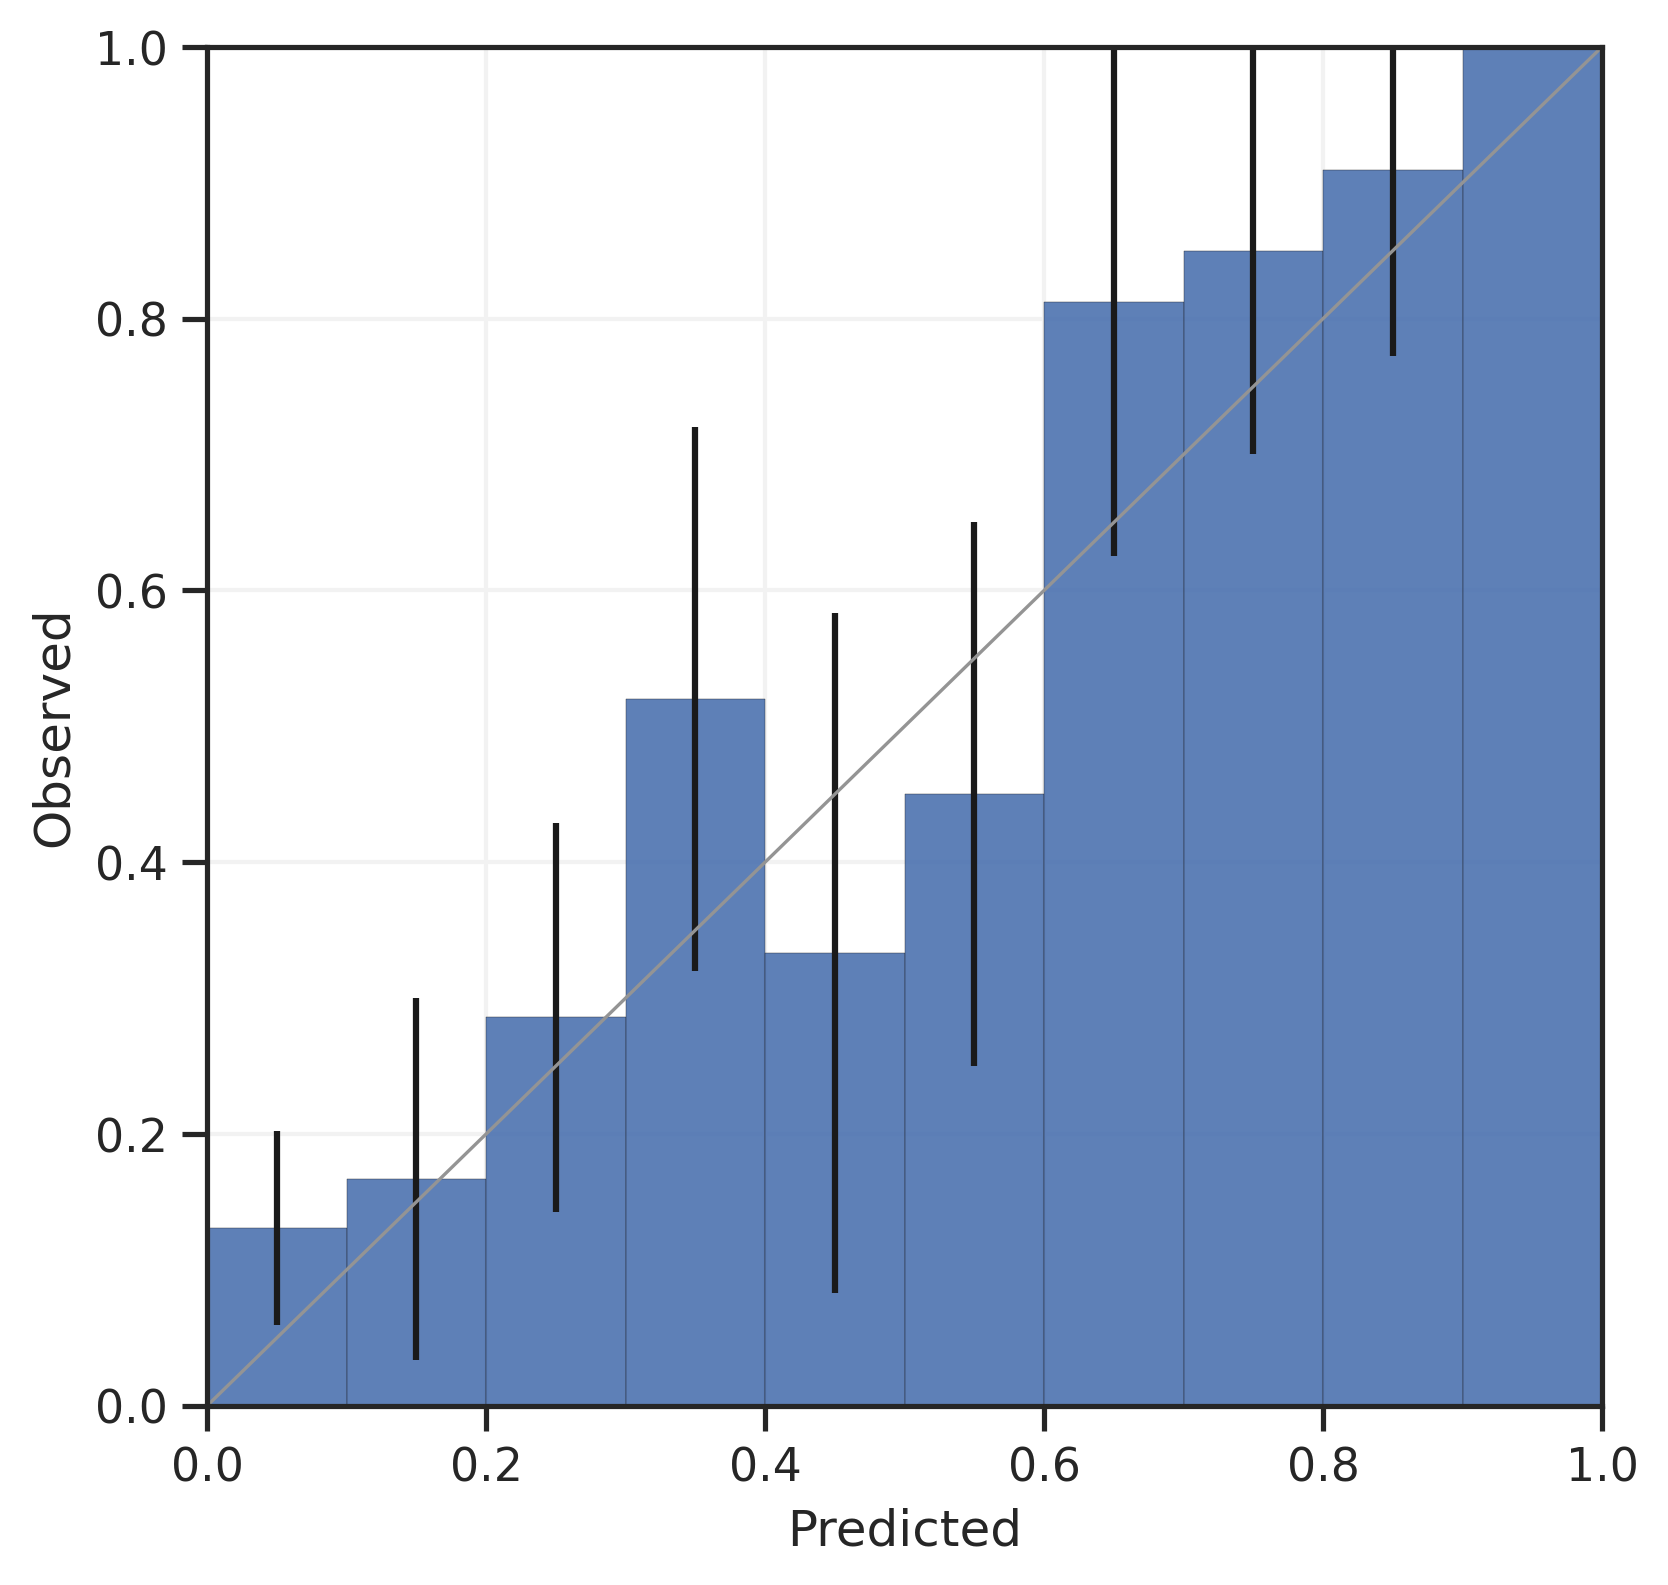

In [10]:
plt.figure(figsize=(6,6), dpi=300)
width = 0.1
xs = np.arange(0.05,1,0.1)
plt.bar(xs,t,width, yerr=ece_ci, align='center', linewidth=0.1, alpha=0.9, edgecolor='k')
plt.plot([0,1],[0,1], color=COLORS[7], linewidth=.8)
plt.ylabel("Observed")
plt.xlabel("Predicted")
plt.ylim(-0.0,1.0)
plt.xlim(-0.0,1.0)

## Mean calibration

In [11]:
df['T2D'].mean(), df['Pred'].mean()

(0.4875, 0.4301385283470154)

<AxesSubplot:>

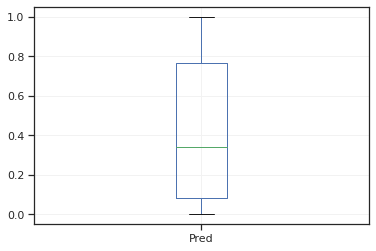

In [12]:
df['Pred'].plot.box()

In [13]:
df['Pred'].describe()

count    320.000000
mean       0.430139
std        0.350998
min        0.000000
25%        0.084162
50%        0.343094
75%        0.768295
max        0.999956
Name: Pred, dtype: float64

In [14]:
df[df["T2D"] == 1].describe()

,T2D,Pred
count,156.0,156.000000
mean,1.0,0.676917
std,0.0,0.304453
min,1.0,0.027573
25%,1.0,0.411050
50%,1.0,0.769516
75%,1.0,0.938420
max,1.0,0.999956


In [15]:
df[df["T2D"] == 0].describe()

,T2D,Pred
count,164.0,164.000000
mean,0.0,0.195398
std,0.0,0.198092
min,0.0,0.000000
25%,0.0,0.042698
50%,0.0,0.121410
75%,0.0,0.291142
max,0.0,0.863881


(array([71., 23., 25., 12., 10.,  7.,  8.,  2.,  4.,  2.]),
 array([0.        , 0.08638807, 0.17277614, 0.25916421, 0.34555228,
        0.43194035, 0.51832842, 0.60471649, 0.69110456, 0.77749262,
        0.86388069]),
 <BarContainer object of 10 artists>)

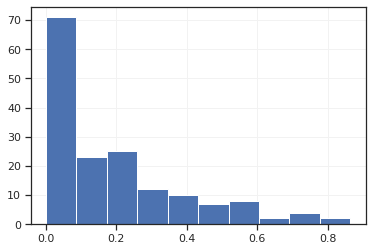

In [16]:
plt.hist(df[df["T2D"] == 0].Pred)

(array([12.,  5.,  9., 13.,  5., 11., 11., 17., 19., 54.]),
 array([0.02757256, 0.12481093, 0.22204931, 0.31928768, 0.41652606,
        0.51376443, 0.61100281, 0.70824118, 0.80547956, 0.90271793,
        0.99995631]),
 <BarContainer object of 10 artists>)

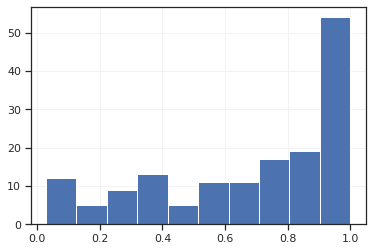

In [17]:
plt.hist(df[df["T2D"] == 1].Pred)